In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,DotProduct
import pandas as pd
import torch

In [2]:
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels
from snorkel.learning.pytorch import LSTM
from scipy import vstack

In [3]:
lstm = LSTM(n_threads=None)


In [4]:
lstm.load('weak_supervision_5_layers')

[LSTM] Loaded model <weak_supervision_5_layers>


In [5]:
session = SnorkelSession()

In [6]:
from snorkel.models import candidate_subclass

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

In [7]:
from snorkel.annotations import load_marginals

train_marginals = load_marginals(session, split=0)

In [8]:
train_cands = session.query(Spouse).filter(Spouse.split == 0).order_by(Spouse.id).all()
dev_cands   = session.query(Spouse).filter(Spouse.split == 1).order_by(Spouse.id).all()
test_cands  = session.query(Spouse).filter(Spouse.split == 2).order_by(Spouse.id).all()

In [13]:
print(len(train_cands), len(dev_cands), len(test_cands))

22254 2811 2701


In [15]:
from snorkel.annotations import load_gold_labels

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [16]:
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)

In [17]:
unid = [i for i,x in enumerate(L_gold_dev.toarray()) if x == 0]

In [18]:
dev_cleaned = [x for i,x in enumerate(dev_cands) if i not in unid]
dev_labels_cleaned = L_gold_dev.toarray().tolist()
dev_labels_cleaned = np.array([x for i,x in enumerate(dev_labels_cleaned) if i not in unid])
dev_labels_cleaned[dev_labels_cleaned==-1] = 0

In [19]:
kernel1 =  RBF(1) + WhiteKernel(noise_level=1) #first attempt at defining a kernel. Not exactly sure what will be best for this or how to tell
kernel2 = RBF(1) + WhiteKernel(noise_level=1)
gpc_dev = GaussianProcessClassifier(kernel = kernel1)
gpc_train = GaussianProcessClassifier(kernel = kernel2)

In [22]:
dev_features = lstm.feature_outputs(dev_cleaned,100).detach().numpy().reshape(2695,10)
test_features = lstm.feature_outputs(test_cands,100).detach().numpy().reshape(2701,10)
train_features = lstm.feature_outputs(train_cands,100).detach().numpy().reshape(22254,10)

In [24]:
train_labels = train_marginals.copy()
train_labels[train_labels > .5] = 1

train_labels[train_labels <= .5] = 0

In [23]:
dev_centered = dev_features - np.mean(dev_features,axis=0)
train_centered = train_features - np.mean(train_features,axis=0)
dev_test_centered = test_features - np.mean(dev_features,axis=0)
train_test_centered = test_features - np.mean(train_features,axis=0)

In [25]:
dev_norm = dev_centered / np.max(dev_centered, axis = 0)
train_norm = train_centered / np.max(train_centered, axis = 0)
dev_test_norm = dev_test_centered / np.max(dev_centered, axis = 0)
train_test_norm = train_test_centered / np.max(train_centered, axis = 0)

In [26]:
gpc_dev.fit(dev_norm,dev_labels_cleaned.reshape(2695,))

GaussianProcessClassifier(copy_X_train=True,
                          kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [27]:
gpc_dev.kernel_

RBF(length_scale=1.89) + WhiteKernel(noise_level=1e-05)

In [33]:
test_features.shape

torch.Size([2701, 10])

In [28]:
gpc_train.fit(train_norm[:3000], train_labels.reshape(22254,)[:3000])

GaussianProcessClassifier(copy_X_train=True,
                          kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [29]:
gpc_train.kernel_

RBF(length_scale=1.09) + WhiteKernel(noise_level=1e-05)

In [31]:
ud = []
ut = []
preds_d = gpc_dev.predict_proba(dev_test_norm, uncertainty = ud)
preds_t = gpc_train.predict_proba(train_test_norm, uncertainty = ut)
ud = np.array(ud[0])
ut = np.array(ut[0])

In [32]:
test_y = L_gold_test.toarray()

In [33]:
unid = [i for i,x in enumerate(test_y) if x == 0]

In [34]:
test_labels_cleaned = test_y.tolist()
test_labels_cleaned = np.array([x for i,x in enumerate(test_labels_cleaned) if i not in unid])
test_labels_cleaned[test_labels_cleaned==-1] = 0

In [35]:
pd = []
for x in preds_d:
    if x[0] > .5:
        pd.append(0)
    else:
        pd.append(1)
pt = []
for x in preds_t:
    if x[0] >.5:
        pt.append(0)
    else:
        pt.append(1)

In [48]:
buckets = np.linspace(-1,1,500)
f1scores = []
acc = []
for b in buckets:
    tp,fp,tn,fn = 0,0,0,0
    for j,p in enumerate(test_labels_cleaned):
        dif_t = abs(preds_t[j][0] - preds_t[j][1])
        dif_d = abs(preds_d[j][0] - preds_d[j][1])
#         t_vote = (1-dif_t) * ct[j]
#         d_vote = (1-dif_d) * cd[j]
        #switch_d = scipy.stats.norm.cdf(.5, max(preds_d[j]), math.sqrt(ud[j]))
        #switch_t = scipy.stats.norm.cdf(.5, max(preds_t[j]), math.sqrt(ut[j]))
        #t_vote = (1-dif_t) # (1- scipy.stats.norm.cdf(.5, dif_t + .5, math.sqrt(ut[j])))# * dif_t
        #d_vote = #(1- scipy.stats.norm.cdf(.5, dif_d + .5, math.sqrt(ud[j])))# * dif_d
        pr = 0
        if dif_t - dif_d < b:
            pr = pd[j]
        else:
            pr = pt[j]
#         if switch_d - switch_t < b:
#             pr = pd[j]
#         else:
#             pr = pt[j]
        if p == 0 and pr == 0:
            tn += 1
        elif p == 0 and pr == 1:
            fp += 1
        elif p == 1 and pr == 0:
            fn += 1
        else: #p == 1 and preds[j] == 1:
            tp += 1
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 / (1/p + 1/r)
    f1scores.append(f1)
    acc.append((tp + tn) / (tp + fn + tn + fp))

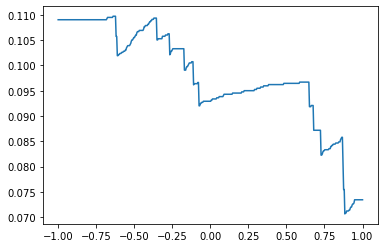

In [49]:
plt.plot(buckets,f1scores)

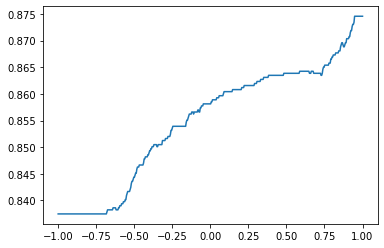

In [50]:
plt.plot(buckets,acc)

In [51]:
buckets = np.linspace(0,.1, 14)

In [52]:
tpfp = []
tnfn = []
f1scores = []
for i in range(13):
    count = 0
    tp,fp,tn,fn = 0,0,0,0
    for j,p in enumerate(dev_labels_cleaned):
        if ud[j] >= buckets[i] and ud[j] < buckets[i+1]:
            count += 1
            if p == 0 and pd[j] == 0:
                tn += 1
            elif p == 0 and pd[j] == 1:
                fp += 1
            elif p == 1 and pd[j] == 0:
                fn += 1
            elif p == 1 and pd[j] == 1:
                tp += 1
    try:
        p = tp / (tp + fp)
    except:
        p = 0
    try:
        r = tp / (tp + fn)
    except: 
        r = 0
    try:
        f1 = 2/(1/p + 1/r)
    except:
        f1 = 0
    try:
        tpfp.append(tp/(tp +fp))
    except:
        tpfp.append(0)
    try:
        tnfn.append(tn/(tn +fn))
    except:
        tnfn.append(0)
    f1scores.append(f1)
    print ("Bucket {}: \n Count: {}\n F1: {}\n{},{},{},{}".format(buckets[i+1], count, f1,tp,fp,tn,fn))

Bucket 0.007692307692307693: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.015384615384615385: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.023076923076923078: 
 Count: 1
 F1: 0
0,0,1,0
Bucket 0.03076923076923077: 
 Count: 84
 F1: 0
0,0,79,5
Bucket 0.038461538461538464: 
 Count: 294
 F1: 0
0,0,271,23
Bucket 0.046153846153846156: 
 Count: 310
 F1: 0
0,3,277,30
Bucket 0.05384615384615385: 
 Count: 282
 F1: 0.11764705882352941
2,8,250,22
Bucket 0.06153846153846154: 
 Count: 298
 F1: 0.08695652173913043
1,12,276,9
Bucket 0.06923076923076923: 
 Count: 243
 F1: 0.06451612903225806
1,10,213,19
Bucket 0.07692307692307693: 
 Count: 180
 F1: 0.058823529411764705
1,21,147,11
Bucket 0.08461538461538462: 
 Count: 180
 F1: 0
0,22,147,11
Bucket 0.09230769230769231: 
 Count: 167
 F1: 0
0,12,141,14
Bucket 0.1: 
 Count: 88
 F1: 0
0,11,73,4


<BarContainer object of 13 artists>

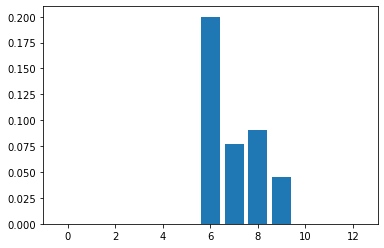

In [53]:
plt.bar(np.arange(13),tpfp)

<BarContainer object of 13 artists>

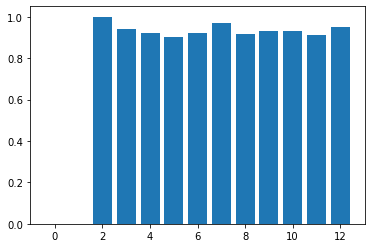

In [54]:
plt.bar(np.arange(13),tnfn)

<BarContainer object of 13 artists>

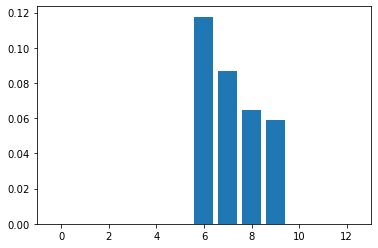

In [55]:
plt.bar(np.arange(13),f1scores)

In [97]:
gpc_high.score(dev_features.detach().numpy(),dev_y)

NameError: name 'gpc_high' is not defined

In [98]:
gpc_high.kernel_

NameError: name 'gpc_high' is not defined